In [2]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import f1_score, accuracy_score
from bs4 import BeautifulSoup
import re
import nltk
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from nltk.corpus import stopwords

import warnings
warnings.filterwarnings("ignore")

In [4]:
df_ = pd.read_csv('/kaggle/input/imdb-dataset-of-50k-movie-reviews/IMDB Dataset.csv')
df_.head(5)

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [5]:
df = df_.copy()

In [6]:
def missing_values_analysis(df):
    na_columns_ = [col for col in df.columns if df[col].isnull().sum() > 0]
    n_miss = df[na_columns_].isnull().sum().sort_values(ascending=True)
    ratio_ = (df[na_columns_].isnull().sum() / df.shape[0] * 100).sort_values(ascending=True)
    missing_df = pd.concat([n_miss, np.round(ratio_, 2)], axis=1, keys=['Total Missing Values', 'Ratio'])
    missing_df = pd.DataFrame(missing_df)
    return missing_df

def check_df(df, head=5):
    print("--------------------- Shape --------------------")
    print(df.shape)
    print("-------------------- Types ---------------------")
    print(df.dtypes)
    print("----------------- NaN Analysis -----------------")
    print(missing_values_analysis(df))
    print("--------------------- Head ---------------------")
    print(df.head())

check_df(df)

--------------------- Shape --------------------
(50000, 2)
-------------------- Types ---------------------
review       object
sentiment    object
dtype: object
----------------- NaN Analysis -----------------
Empty DataFrame
Columns: [Total Missing Values, Ratio]
Index: []
--------------------- Head ---------------------
                                              review sentiment
0  One of the other reviewers has mentioned that ...  positive
1  A wonderful little production. <br /><br />The...  positive
2  I thought this was a wonderful way to spend ti...  positive
3  Basically there's a family where a little boy ...  negative
4  Petter Mattei's "Love in the Time of Money" is...  positive


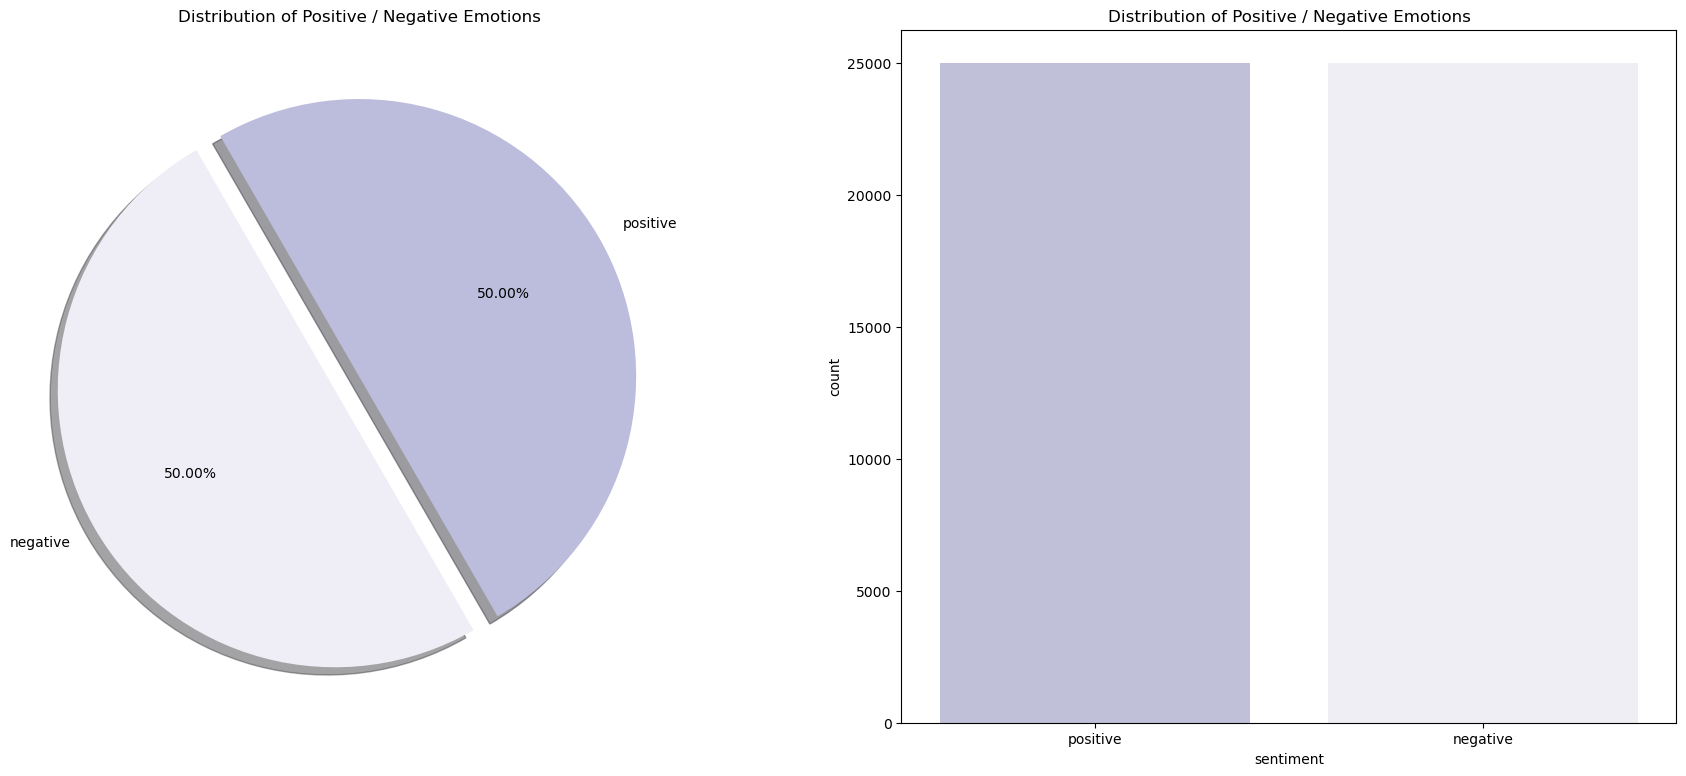

In [7]:
a , ax = plt.subplots(1,2,figsize=(22,9))
df['sentiment'].value_counts().plot.pie(explode=[0,0.1], autopct='%1.2f%%',ax=ax[0],shadow=True, startangle=300, colors = ["#bcbddc", "#efedf5"])
ax[0].set_title('Distribution of Positive / Negative Emotions')
ax[0].set_ylabel('')
sns.countplot(x ='sentiment', data = df ,ax=ax[1], palette=["#bcbddc", "#efedf5"])
ax[1].set_title('Distribution of Positive / Negative Emotions')
plt.show()

In [8]:
df.groupby(['sentiment'])[['sentiment']].count()

,sentiment
sentiment,
negative,25000
positive,25000


In [9]:
example_review = df.review[0]
example_review

"One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me.<br /><br />The first thing that struck me about Oz was its brutality and unflinching scenes of violence, which set in right from the word GO. Trust me, this is not a show for the faint hearted or timid. This show pulls no punches with regards to drugs, sex or violence. Its is hardcore, in the classic use of the word.<br /><br />It is called OZ as that is the nickname given to the Oswald Maximum Security State Penitentary. It focuses mainly on Emerald City, an experimental section of the prison where all the cells have glass fronts and face inwards, so privacy is not high on the agenda. Em City is home to many..Aryans, Muslims, gangstas, Latinos, Christians, Italians, Irish and more....so scuffles, death stares, dodgy dealings and shady agreements are never far away.<br /><br />I would say the main appeal of the show is due to the fa

In [10]:
# After cleaning the HTML tags... 😌
example_review = BeautifulSoup(example_review).get_text()
example_review

"One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me.The first thing that struck me about Oz was its brutality and unflinching scenes of violence, which set in right from the word GO. Trust me, this is not a show for the faint hearted or timid. This show pulls no punches with regards to drugs, sex or violence. Its is hardcore, in the classic use of the word.It is called OZ as that is the nickname given to the Oswald Maximum Security State Penitentary. It focuses mainly on Emerald City, an experimental section of the prison where all the cells have glass fronts and face inwards, so privacy is not high on the agenda. Em City is home to many..Aryans, Muslims, gangstas, Latinos, Christians, Italians, Irish and more....so scuffles, death stares, dodgy dealings and shady agreements are never far away.I would say the main appeal of the show is due to the fact that it goes where other shows wo

In [11]:
# we clean it from punctuation and numbers - using regex. {Regular expression}
example_review = re.sub("[^a-zA-Z]",' ',example_review)
example_review

'One of the other reviewers has mentioned that after watching just   Oz episode you ll be hooked  They are right  as this is exactly what happened with me The first thing that struck me about Oz was its brutality and unflinching scenes of violence  which set in right from the word GO  Trust me  this is not a show for the faint hearted or timid  This show pulls no punches with regards to drugs  sex or violence  Its is hardcore  in the classic use of the word It is called OZ as that is the nickname given to the Oswald Maximum Security State Penitentary  It focuses mainly on Emerald City  an experimental section of the prison where all the cells have glass fronts and face inwards  so privacy is not high on the agenda  Em City is home to many  Aryans  Muslims  gangstas  Latinos  Christians  Italians  Irish and more    so scuffles  death stares  dodgy dealings and shady agreements are never far away I would say the main appeal of the show is due to the fact that it goes where other shows wo

In [12]:
example_review = example_review.lower()
example_review
     

'one of the other reviewers has mentioned that after watching just   oz episode you ll be hooked  they are right  as this is exactly what happened with me the first thing that struck me about oz was its brutality and unflinching scenes of violence  which set in right from the word go  trust me  this is not a show for the faint hearted or timid  this show pulls no punches with regards to drugs  sex or violence  its is hardcore  in the classic use of the word it is called oz as that is the nickname given to the oswald maximum security state penitentary  it focuses mainly on emerald city  an experimental section of the prison where all the cells have glass fronts and face inwards  so privacy is not high on the agenda  em city is home to many  aryans  muslims  gangstas  latinos  christians  italians  irish and more    so scuffles  death stares  dodgy dealings and shady agreements are never far away i would say the main appeal of the show is due to the fact that it goes where other shows wo

In [13]:
example_review = example_review.split()

In [14]:
words = set(stopwords.words("english")) # conversion into set for fast searching !!!
example_review = [word for word in example_review if word not in words]              
example_review

['one',
 'reviewers',
 'mentioned',
 'watching',
 'oz',
 'episode',
 'hooked',
 'right',
 'exactly',
 'happened',
 'first',
 'thing',
 'struck',
 'oz',
 'brutality',
 'unflinching',
 'scenes',
 'violence',
 'set',
 'right',
 'word',
 'go',
 'trust',
 'show',
 'faint',
 'hearted',
 'timid',
 'show',
 'pulls',
 'punches',
 'regards',
 'drugs',
 'sex',
 'violence',
 'hardcore',
 'classic',
 'use',
 'word',
 'called',
 'oz',
 'nickname',
 'given',
 'oswald',
 'maximum',
 'security',
 'state',
 'penitentary',
 'focuses',
 'mainly',
 'emerald',
 'city',
 'experimental',
 'section',
 'prison',
 'cells',
 'glass',
 'fronts',
 'face',
 'inwards',
 'privacy',
 'high',
 'agenda',
 'em',
 'city',
 'home',
 'many',
 'aryans',
 'muslims',
 'gangstas',
 'latinos',
 'christians',
 'italians',
 'irish',
 'scuffles',
 'death',
 'stares',
 'dodgy',
 'dealings',
 'shady',
 'agreements',
 'never',
 'far',
 'away',
 'would',
 'say',
 'main',
 'appeal',
 'show',
 'due',
 'fact',
 'goes',
 'shows',
 'dare',
 

In [15]:
def process(review):
    # review without HTML tags
    review = BeautifulSoup(review).get_text()
    # review without punctuation and numbers
    review = re.sub("[^a-zA-Z]",' ',review)
    # converting into lowercase and splitting to eliminate stopwords
    review = review.lower()
    review = review.split()
    # review without stopwords
    swords = set(stopwords.words("english"))  # conversion into set for fast searching
    review = [w for w in review if w not in swords]               
    # splitted paragraph'ları space ile birleştiriyoruz return
    return(" ".join(review))

In [16]:
# We can see the status of the review process by printing a line after every 2500 reviews.

train_data = []
for i in range(len(df["review"])):        
    if (i+1)%2500 == 0:        
        print("Result =", i+1)
    train_data.append(process(df["review"][i]))

Result = 2500
Result = 5000
Result = 7500
Result = 10000
Result = 12500
Result = 15000
Result = 17500
Result = 20000
Result = 22500
Result = 25000
Result = 27500
Result = 30000
Result = 32500
Result = 35000
Result = 37500
Result = 40000
Result = 42500
Result = 45000
Result = 47500
Result = 50000


In [17]:
independent = train_data
dependent = np.array(df["sentiment"])

train_x, test_x, y_train, y_test = train_test_split(independent,dependent, stratify = dependent ,test_size = 0.2, shuffle = True , random_state = 25)
     


In [18]:
# Using the countvectorizer function in sklearn, we create a bag of words with a maximum of 10.000 words...
vectorizer = CountVectorizer( max_features = 10000 )

# we convert our train data to feature vector matrix
train_x = vectorizer.fit_transform(train_x)

In [19]:
vectorizer

CountVectorizer(max_features=10000)

In [20]:
train_x

<40000x10000 sparse matrix of type '<class 'numpy.int64'>'
	with 3439274 stored elements in Compressed Sparse Row format>

In [21]:
# Since our machine learning algorithm requires an array for the training process, we convert it to an array.
train_x = train_x.toarray()
train_y = y_train

In [23]:
print("Total training data :", train_x.shape[0])
print("Total training data :", train_y.shape[0])

Total training data : 40000
Total training data : 40000


In [24]:
models = []

models.append(('Logistic Regression',LogisticRegression()))
models.append(('Random Forest Classifier',RandomForestClassifier()))
models.append(('Decision Tree Classifier',DecisionTreeClassifier()))

In [25]:
# We convert our test data to vector matrix feature
#This time for our test:
test_result = vectorizer.transform(test_x)

In [26]:
test_result = test_result.toarray()

In [27]:
test_result.shape

(10000, 10000)

In [28]:
for name, model in models:

    %time model.fit(train_x, train_y)
    test_pred = model.predict(test_result)
    print(name ,'Accuracy Score : ',accuracy_score(y_test, test_pred))
    print(name ,'F1 Score : ',f1_score(y_test, test_pred, average='weighted'))
    print('-----------------------------------------------------------------------')
     

CPU times: user 2min 2s, sys: 5.52 s, total: 2min 8s
Wall time: 35.1 s
Logistic Regression Accuracy Score :  0.8767
Logistic Regression F1 Score :  0.8766926891095372
-----------------------------------------------------------------------
CPU times: user 2min 31s, sys: 461 ms, total: 2min 32s
Wall time: 2min 32s
Random Forest Classifier Accuracy Score :  0.8481
Random Forest Classifier F1 Score :  0.8480998769609003
-----------------------------------------------------------------------
CPU times: user 3min 16s, sys: 290 ms, total: 3min 16s
Wall time: 3min 16s
Decision Tree Classifier Accuracy Score :  0.7215
Decision Tree Classifier F1 Score :  0.7214748631063953
-----------------------------------------------------------------------
